<a href="https://colab.research.google.com/github/dharapatel9/EconomicForecasting/blob/main/Economic%20Forecasting%20Project_2_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 2
Instructions: 
- Please read the project description before your start.
- To save a copy of your ipython notebook: click ```File -> Download .ipyhon```
- Write your code in the code cells below each Step description. You may add extra cells if needed.


In [ ]:
# Run this cell as the first step to make sure we use the most updated version of statsmodels in python
# If it fails to import the latest version, try click Runtime -> Restart runtime and start from here again
!pip install statsmodels==0.12.0
import statsmodels

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

!pip install arch
from arch import arch_model

## Modeling volatility using US Dollar / Australian Dollar exchange rate data
Step 1: import data from Github
- Check to see that DataFrame usdaud a column ```USDAUD```, which is the USD/AUD exchange rate
- The sample is daily and covers the period from Jan 2, 2001 to Oct 14, 2004

In [ ]:
usdaud = pd.read_csv('https://raw.githubusercontent.com/shihanxie/Econ475/main/data/usdaud.csv', 
                     na_values = '.', dtype={'USDAUD': np.float})
usdaud.index = pd.date_range(start='2001-01-02', periods= usdaud.shape[0], freq='D')
usdaud.head()

,USDAUD
2001-01-02,0.5592
2001-01-03,0.5635
2001-01-04,0.5655
2001-01-05,0.5712
2001-01-06,0.5660


Step 2: Compute and plot the first difference of the log(exchange rate), or $\Delta \log(usdaud_t) \times 100$. From now on, we will use $y_t$ to refer $\Delta \log(usdaud_t) \times 100$, which is the daily percentage change in USD/AUD exchange rate.

Hint: use ```np.log(var).diff()``` to compute the first difference of the log of ```var```.

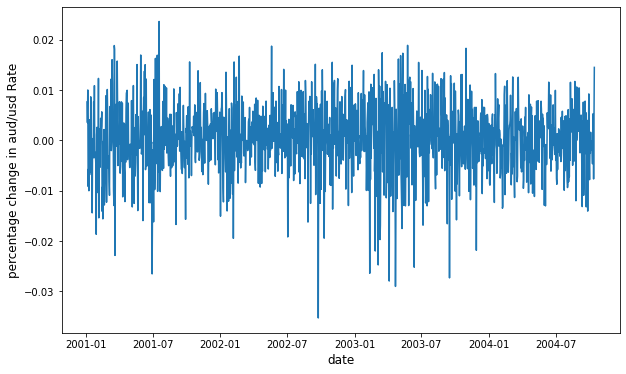

In [ ]:
usdaud['y_t'] = np.log(usdaud['USDAUD']*100).diff()

plt.figure(figsize=(10,6))
plt.plot(usdaud['y_t'])
ax = plt.gca()
ax.set_ylabel('percentage change in aud/usd Rate', fontsize = 'large')
ax.set_xlabel('date', fontsize = 'large')
plt.show()


Step 3: Plot the histogram and compute the descriptive statistics of $y_t$. Conduct the proper test to see if it is normally distributed.

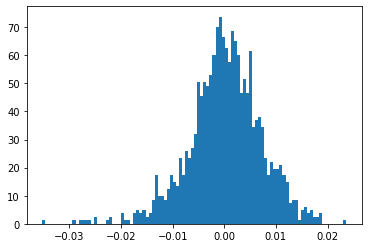

count    1381.000000
mean        0.000205
std         0.006999
min        -0.035291
25%        -0.003773
50%         0.000366
75%         0.004633
max         0.023646
Name: y_t, dtype: float64
Skewness:  -0.4365038830558965
Kurtosis:  1.3804256502583216
Jarque-Bera test statistic is:  151.9317835684659
Jarque-Bera test p-value is:  0.0


In [ ]:
_,bins,_ = plt.hist(usdaud['y_t'],density = 1, bins=100)
plt.show()
print(usdaud['y_t'].describe())
print('Skewness: ', usdaud['y_t'].skew())
print('Kurtosis: ', usdaud['y_t'].kurt())
print('Jarque-Bera test statistic is: ', stats.jarque_bera(usdaud['y_t'].dropna())[0])
print('Jarque-Bera test p-value is: ', stats.jarque_bera(usdaud['y_t'].dropna())[1])

Step 4: Compare the historgram of $y_t$ to a normal distribution.

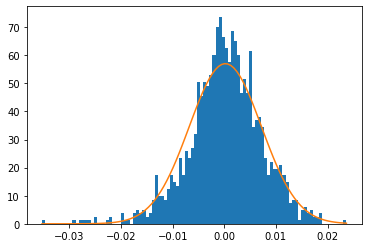

In [ ]:
mu, sigma = stats.norm.fit(usdaud['y_t'].dropna())
best_fit_line = stats.norm.pdf(bins, mu, sigma)
plt.hist(usdaud['y_t'],density = 1, bins=100)
plt.plot(bins, best_fit_line)
plt.show()

Step 5: Compute the correlogram of squared $y_t$ up to 12 lags.

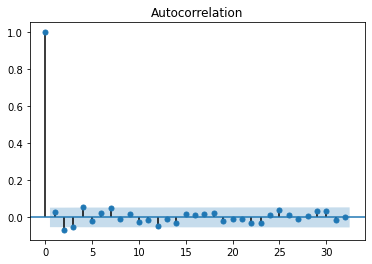

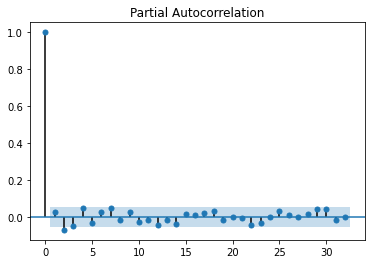

In [ ]:
usdaud['y_t_2'] = usdaud['y_t'] ** 2
usdaud.head()

plot_acf(usdaud['y_t'].dropna())
plot_pacf(usdaud['y_t'].dropna())
plt.show()

Step 6: Estimate an AR(1) model for squared $y_t$

In [ ]:
result_ar1 = ARIMA(usdaud['y_t_2'], order=(1,0,0)).fit()
print(result_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:                  y_t_2   No. Observations:                 1382
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10919.500
Date:                Fri, 30 Apr 2021   AIC                         -21833.000
Time:                        23:56:50   BIC                         -21817.307
Sample:                    01-02-2001   HQIC                        -21827.130
                         - 10-14-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.898e-05   3.99e-06     12.285      0.000    4.12e-05    5.68e-05
ar.L1          0.0592   1.27e-10   4.67e+08      0.000       0.059       0.059
sigma2      7.938e-09   1.04e-10     75.976      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Step 7: Estimate an ARCH(1) model and a GARCH(1,1) model for
$$
\begin{aligned}
&y_t =\mu+\varepsilon_{t} \\
&\varepsilon_{t} \mid \Omega_{t-1} \sim N\left(0, \sigma_{t}^{2}\right)
\end{aligned}
$$

In [ ]:
result_arch1 = arch_model(usdaud['y_t'].dropna(), vol='Garch', p=1, q=0, dist='Normal').fit()
print(result_arch1.summary())

result_garch1 = arch_model(usdaud['y_t'].dropna(), vol='Garch', p=1, q=1, dist='Normal').fit()
print(result_garch1.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4789.607052252159
Iteration:      2,   Func. Count:     18,   Neg. LLF: -4791.300838261624
Iteration:      3,   Func. Count:     31,   Neg. LLF: -4791.30087819885
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4791.300876284174
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                    y_t   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                4791.30
Distribution:                  Normal   AIC:                          -9576.60
Method:            Maximum Likelihood   BIC:                          -9560.91
                                        No. Observations:                 1381
Date:               

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.895e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.895e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), D

Step 8: Estimate an AR(1)-ARCH(1) model and an AR(1)-GARCH(1,1) model for
$$
\begin{aligned}
&y_t =\mu+\rho y_{t-1} + \varepsilon_{t} \\
&\varepsilon_{t} \mid \Omega_{t-1} \sim N\left(0, \sigma_{t}^{2}\right)
\end{aligned}
$$

In [ ]:
# # arch model
# result_arch5 = arch_model(stock['SP500'].dropna(), vol='Garch', p=5, q=0, dist='Normal').fit()

# #garch model
# result_garch = arch_model(stock['SP500'].dropna(), vol='Garch', p=1, q=1, dist='Normal').fit()

#ar and garch
result_ar_arch = arch_model(usdaud['y_t'].dropna(), mean='AR', lags = 1, vol='Garch', p=1, q=0, dist='Normal').fit()
result_ar_garch = arch_model(usdaud['y_t'].dropna(), mean='AR', lags = 1, vol='Garch', p=1, q=1, dist='Normal').fit()
print(result_ar_arch.summary())
print(result_ar_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: -4787.037508896044


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.891e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      2,   Func. Count:     20,   Neg. LLF: -4788.650447642451
Iteration:      3,   Func. Count:     33,   Neg. LLF: -4788.650900016628
Iteration:      4,   Func. Count:     49,   Neg. LLF: -4786.906950993203
Iteration:      5,   Func. Count:     63,   Neg. LLF: -4788.647370133324
Iteration:      6,   Func. Count:     77,   Neg. LLF: -4788.64905580851
Iteration:      7,   Func. Count:     93,   Neg. LLF: -4787.332580283757
Iteration:      8,   Func. Count:    109,   Neg. LLF: -4610.889764845022
Iteration:      9,   Func. Count:    125,   Neg. LLF: -1906.042609448407
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1906.0425060533962
            Iterations: 13
            Function evaluations: 125
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      7,   Neg. LLF: -4923.38196527427
Iteration:      2,   Func. Count:     22,   Neg. LLF: -4923.447014838881
Optimization terminated successfully.    (Exit mode 0)
     

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.891e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Step 9: Plot the estimated conditional variance of the best-fitting model among the ones considered

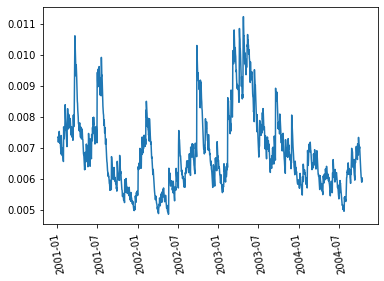

In [ ]:
# GARCHMODEL (1,1) best fit to the data

plt.plot(result_garch1.conditional_volatility)
plt.plot(result)
ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 100)
plt.show()